## Laden van de data

Laden van de data per-maand. Zag ~7000 data entries in een maand.(alle magnitudes)
Hetzelfde over ~50 jaar is ~4M entries

In [1]:
import timeit

import pandas
from dateutil import parser

from pathlib import Path
from urllib import request

def raw_get_query(file, args):
    url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?' + args
    print(url)
    r = request.urlopen(url)
    if r.getcode() == 200:
        with open(file, 'w') as fd:
            for line in r.readlines():
                fd.write(line.decode())# + "\n")

    r.close()

    
def load_file(file):
    got = pandas.read_csv(file)
    got.time = [parser.parse(time) for time in got.time]
    return got

def get_query(year, month, min_mag=3.5):
    file = "data/{}-{}.csv".format(year, month)
    if not Path(file).exists():
        print('obtain', file)
        next_month, maybe_next_year = month + 1, year
        if next_month > 12:
            maybe_next_year = year + 1
            next_month = 1
        fmt_str = "format=csv&starttime={}-{}-01&endtime={}-{}-01&minmagnitude={}"
        arg = fmt_str.format(year, month, maybe_next_year, next_month, min_mag)
        raw_get_query(file, arg)

    return load_file(file)

def month_range(from_year, from_month, to_year, to_month):
    y,m = from_year, from_month
    while y < to_year:
        while m <= 12:
            yield(y, m)
            m = m + 1
        m = 1
        y = y +1

    if y == to_year:
        while m < to_month:
            yield(y,m)
            m = m + 1

def time_whine(gen, interval=10, whiny='i got'):
    next_whine = timeit.time.time() + interval
    for got in gen:
        if next_whine < timeit.time.time():
            print(whiny, got)
            next_whine = timeit.time.time() + interval
        yield got

def get_time_range(month_generator, prep=lambda x: x):
    return pandas.concat([prep(get_query(year, month)) for year,month in month_generator])

In [2]:
data = get_time_range(time_whine(month_range(1970,1, 2018,1)), lambda x: x[x.mag > 3.5])

i got (1979, 6)
i got (1982, 11)
i got (1984, 11)
i got (1986, 8)
i got (1988, 10)
i got (1990, 10)
i got (1992, 8)
i got (1993, 12)
i got (1995, 8)
i got (1997, 4)
i got (1998, 10)
i got (2000, 7)
i got (2002, 5)
i got (2004, 1)
i got (2005, 4)
i got (2006, 8)
i got (2008, 3)
i got (2009, 6)
i got (2010, 8)
i got (2011, 11)
i got (2013, 2)
i got (2014, 1)
i got (2014, 11)
i got (2015, 9)
i got (2016, 7)
i got (2017, 5)


**TODO** Er zijn dubbele...

In [3]:
len(data.id) - len(data.id.unique())

462

In [4]:
data[:3]

time   latitude   longitude  depth   mag  \
6  1970-01-30 17:00:00.720000+00:00  37.030833 -116.034833    0.3  4.09   
7         1970-01-30 08:28:22+00:00 -14.575000  167.340000  164.9  5.90   
11        1970-01-28 23:06:02+00:00 -20.672000 -178.766000  605.9  6.10   

   magType   nst    gap   dmin   rms    ...                      updated  \
6       ml  13.0  253.0  1.749  0.31    ...     2016-01-29T01:29:03.020Z   
7       mw   NaN    NaN    NaN   NaN    ...     2015-07-13T17:02:24.000Z   
11      mw   NaN    NaN    NaN   NaN    ...     2015-05-13T18:53:03.000Z   

                     place               type horizontalError depthError  \
6   65km ENE of Beatty, NV  nuclear explosion            99.0      31.61   
7                  Vanuatu         earthquake             NaN        NaN   
11             Fiji region         earthquake             NaN        NaN   

    magError  magNst     status  locationSource magSource  
6      0.173    12.0   reviewed              ci        ci  
7        NaN     NaN  automatic          iscgem    iscgem  
11       NaN     NaN  automatic          iscgem    iscgem  

[3 rows x 22 columns]

## Waar zijn de aarbevingen?

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

%matplotlib inline
pandas.options.mode.chained_assignment = None

Plot van de wereld Hogere magnitudes zijn paars.

In [6]:
gdf_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
def plot_world(ax):
    gdf_countries.plot(ax=ax, color='lightgrey')

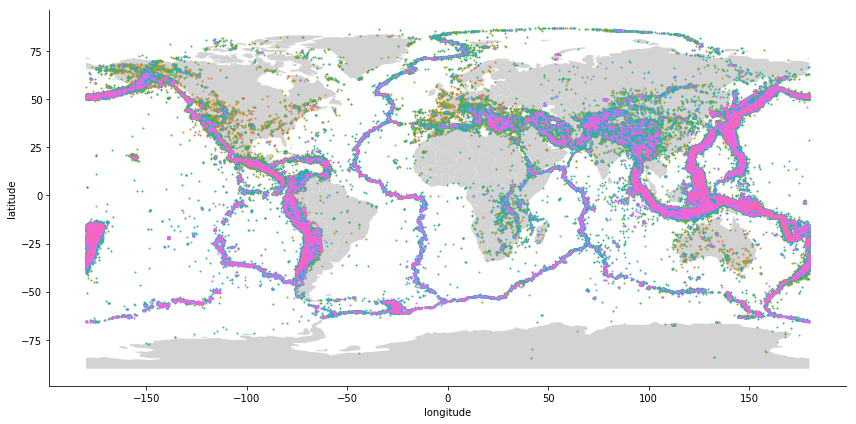

In [7]:
g = sns.FacetGrid(data=data, hue='mag', size=6, aspect=2)
plot_world(g.axes[0][0])
g.map(plt.scatter, 'longitude', 'latitude', s=1)

In [8]:
data.type.unique()

array(['nuclear explosion', 'earthquake', 'quarry blast', 'explosion',
       'mine collapse', 'other event', 'rock burst', 'sonic boom',
       'mining explosion', 'experimental explosion', 'landslide',
       'collapse'], dtype=object)

942

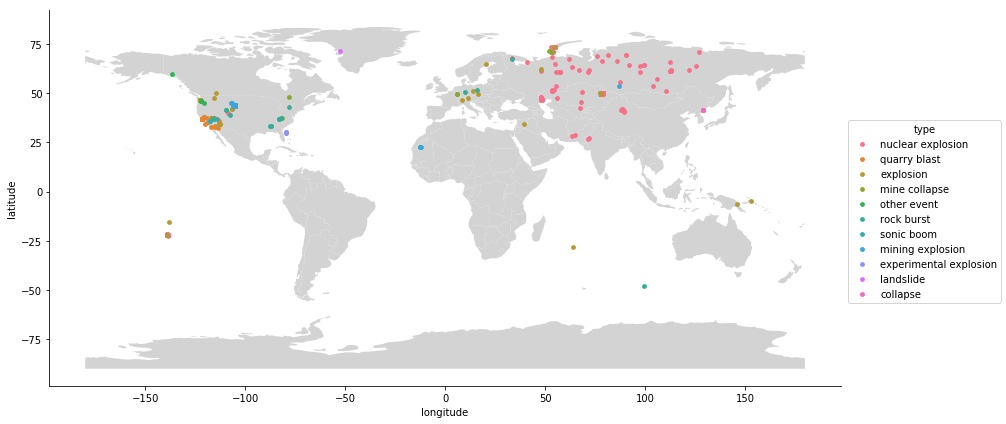

In [9]:
g = sns.FacetGrid(data=data[data.type != 'earthquake'], hue='type', size=6, aspect=2)
plot_world(g.axes[0][0])
g.map(plt.scatter, 'longitude', 'latitude', s=14).add_legend()
len(data[data.type != 'earthquake'])

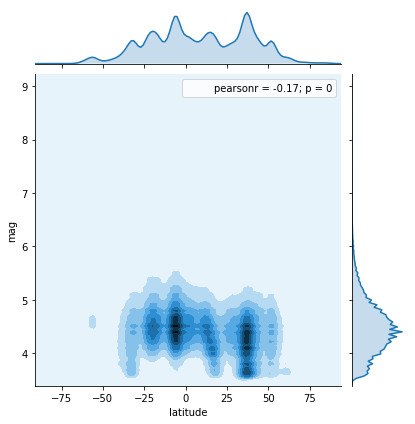

In [10]:
sns.jointplot(data=data, x='latitude', y='mag', kind='kde')

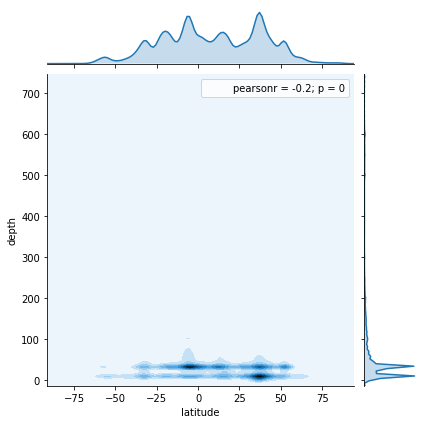

In [11]:
sns.jointplot(data=data, x='latitude', y='depth', kind='kde')

**TODO** kunnen we een videotje maken?

### Verdeling van de sterkte

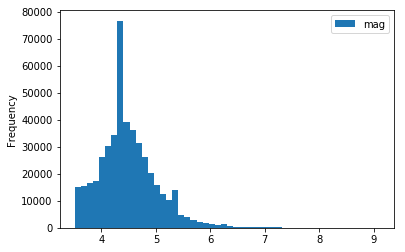

In [12]:
data.plot.hist(y='mag', bins=50)

### Halfrond & effecten van detectie-efficiency
Welk halfrond komen er meer voor? `[data.mag>5]` scheelt veel, weer doordat ze in delen van de wereld makkelijker
gedetecteerd worden.

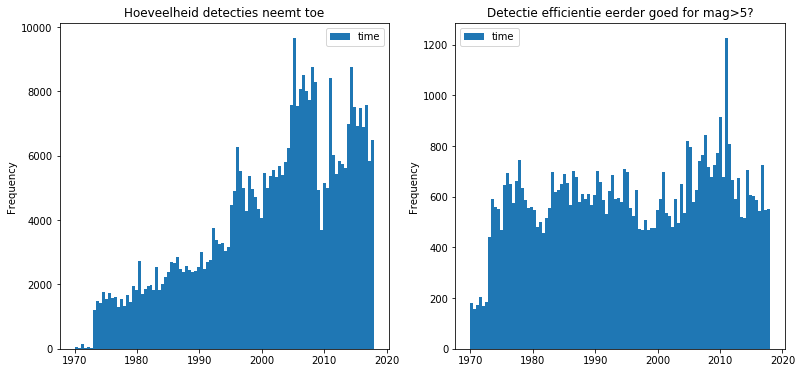

In [15]:
import datetime
year_seconds = 365.25*24*3600

def year_continuous(t):  # time in years.
    year = t.year
    return year + (t.timestamp() - datetime.datetime(year,1,1).timestamp())/year_seconds


fig, ax = plt.subplots(1,2, figsize=(13,6))

p = data[data.mag <= 5][['time']].applymap(year_continuous).plot
p.hist(y='time', ax=ax[0], title="Hoeveelheid detecties neemt toe", bins=100)
p = data[data.mag > 5][['time']].applymap(year_continuous).plot
p.hist(y='time', ax=ax[1],title="Detectie efficientie eerder goed for mag>5?", bins=100)

## Diepte van aarbevingen
Locaties hebben wellicht bepaald character?

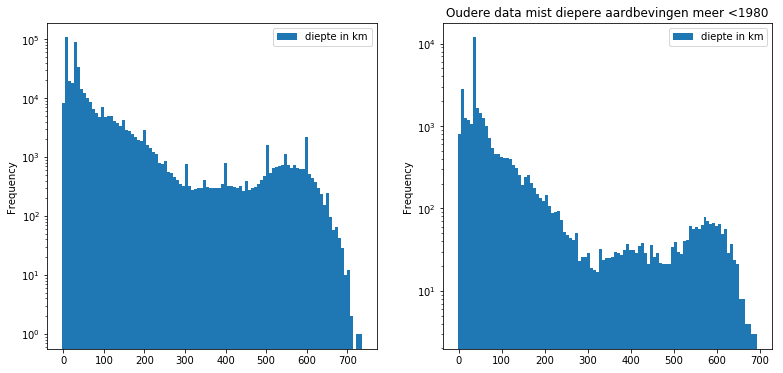

In [16]:
fig, ax = plt.subplots(1,2, figsize=(13,6))

data[data.time >= '1980'].plot.hist(y='depth', label='diepte in km', bins=100, logy=True, ax=ax[0])
data[data.time < '1980'].plot.hist(y='depth', label='diepte in km',
                                   title='Oudere data mist diepere aardbevingen meer <1980',
               bins=100, logy=True, ax=ax[1])

### Verband diepte/magnitude
Beetje jammer dat de `plt.hist2d` en `sns` histogrammen/kdes niet logirithmisch kunnen.
Onbegrijpelijk, lijkt me een open deur. (dataframes heeft niet eens 2d histogrammen.)

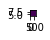

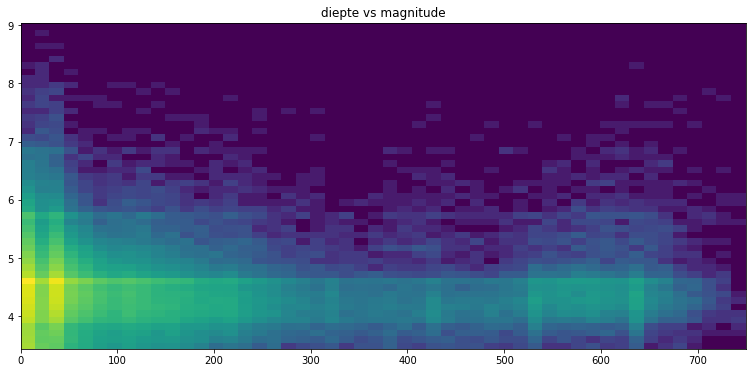

In [17]:
p2000 = data[data.time>'2000']

import math
import numpy as np

plt.subplots(figsize=(0.1,0.1))
array = plt.hist2d(p2000.depth, p2000.mag, bins=(50,50), range=[[0,700],[3.5,9]])[0]
array = np.array([[math.log10(el+1) for el in row] for row in array]).transpose()


fig, ax = plt.subplots(figsize=(13,6))
c = ax.pcolor(array)
ax.set_title('diepte vs magnitude')

xtickvals = list(range(0, 750, 100))
ax.set_xticks([50*x/750 for x in xtickvals])
ax.set_xticklabels(xtickvals)

ax.set_yticks([0.5+ 50*(i-3.5)/5.6 for i in range(4,10)])
ax.set_yticklabels(list(range(4,10))) #position=(-30,0))

#fig.tight_layout()
plt.show()

### Halfrond & effecten van detectie-efficiency
Welk halfrond komen er meer voor? `[data.mag>5]` scheelt veel, weer doordat ze in delen van de wereld makkelijker
gedetecteerd worden.

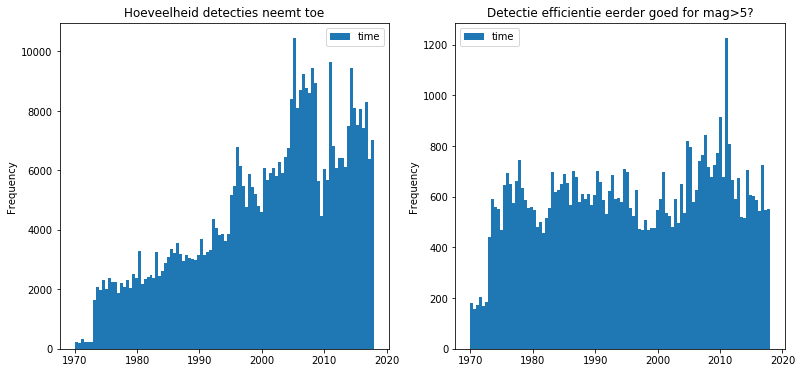

In [18]:
import datetime
year_seconds = 365.25*24*3600

def year_continuous(t):  # time in years.
    year = t.year
    return year + (t.timestamp() - datetime.datetime(year,1,1).timestamp())/year_seconds


fig, ax = plt.subplots(1,2, figsize=(13,6))

data[['time']].applymap(year_continuous).plot.hist(ax=ax[0], title="Hoeveelheid detecties neemt toe", bins=100)
p = data[data.mag > 5][['time']].applymap(year_continuous).plot
p.hist(ax=ax[1],title="Detectie efficientie eerder goed for mag>5?", bins=100)

## Haiti sinds 2010

In [19]:
def find_place(name):
    name = name.lower()
    return data[[type(place)==str and place.lower().find(name) >=0 for place in data.place]]

haiti = find_place('haiti')
haiti = haiti[(haiti.time > '2009') & (haiti.time<'2011')]
year_continuous(haiti.time.sort_values()[0])

2010.0327271421147

In [20]:
haiti.sort_values('mag', ascending=False)[:2]

time  latitude  longitude  depth  mag  \
3639 2010-01-12 21:53:10.060000+00:00    18.443    -72.571   13.0  7.0   
3638 2010-01-12 22:00:41.490000+00:00    18.387    -72.784   10.0  6.0   

     magType    nst   gap  dmin   rms    ...                      updated  \
3639     mwc  500.0  22.7   NaN  0.97    ...     2017-11-13T18:37:10.668Z   
3638     mwc  196.0  24.1   NaN  0.84    ...     2017-04-26T18:10:01.066Z   

             place        type horizontalError depthError  magError  magNst  \
3639  Haiti region  earthquake             NaN        NaN       NaN     NaN   
3638  Haiti region  earthquake             NaN        NaN       NaN     NaN   

        status  locationSource magSource  
3639  reviewed              us        us  
3638  reviewed              us      gcmt  

[2 rows x 22 columns]

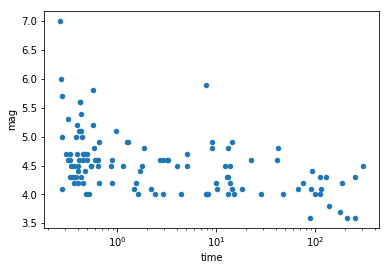

In [21]:
df = pandas.DataFrame({'time':[365.25*(year_continuous(t)-2010.032) for t in haiti.time],
                       'mag':haiti.mag, 'depth':haiti.depth})

df.plot.scatter(x='time', y='mag', logx=True)

## Kathmandu(Nepal) sinds 2015

Twee hoofd gevallen.

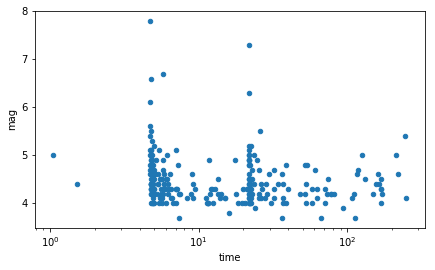

In [22]:
kathmandu = find_place('nepal')
kathmandu = kathmandu[(kathmandu.time > '2015.4') & (kathmandu.time < '2016')]

df = pandas.DataFrame({'time':[365.25*(year_continuous(t)-2015.3) for t in kathmandu.time], 'mag':kathmandu.mag})
df.plot.scatter(x='time', y='mag', logx=True, figsize=(7,4))

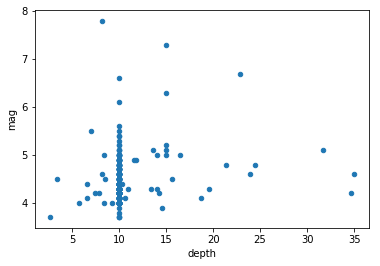

In [23]:
kathmandu.plot.scatter(x='depth', y='mag')

## De sterkste aardbevingen

In [25]:
from math import cos,sin

def unit_sphere(long, lat):  # In angles.
    lat, long = math.pi*lat/180, math.pi*long/180
    return (cos(long)*cos(lat), sin(long)*cos(lat), sin(lat))

def loc_dist(a, b):
    return math.sqrt(sum((ca-cb)**2 for ca, cb in zip(unit_sphere(*a), unit_sphere(*b))))*360/(2*math.pi)

def get_area_and_time(df, at_pos, at_t, da, dt):
    return df[[(abs(at_t.timestamp() - t.timestamp()) < dt and loc_dist(at_pos, pos) < da)
               for (t,*pos) in zip(df.time, df.longitude, df.latitude)]]

Deze duurt onnodig lang..

In [ ]:
big = data[data.mag > 7]
areas = []
for t,*pos in zip(big.time, big.longitude, big.latitude):
    areas.append(get_area_and_time(data, pos, t, 4, 7*24*3600))

In [ ]:
list(map(len, areas))

In [ ]:
for i, area in zip(range(len(areas)), areas):
    area.to_csv('data/bigones/{}.csv'.format(i))

In [29]:
event = data.sort_values('mag', ascending=False)
omgeving1 = get_area_and_time(data, (95.982, 3.295), event.time[0], 4, 7*24*3600)

942

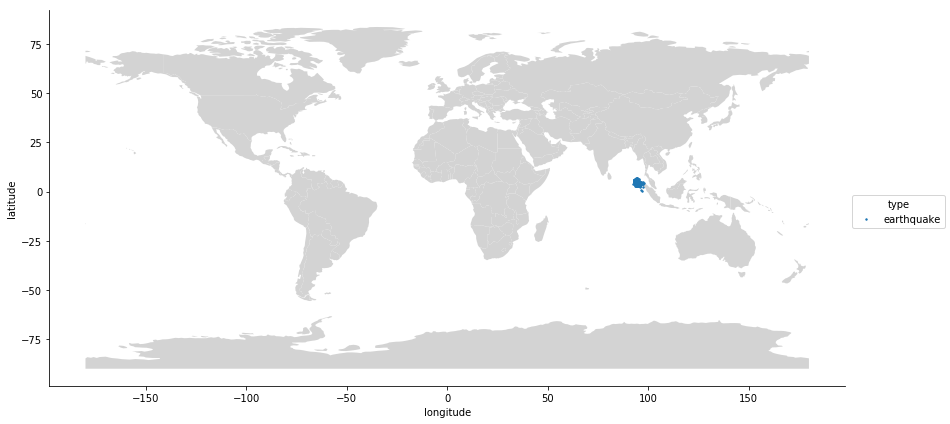

In [30]:
g = sns.FacetGrid(data=omgeving1, hue='type', size=6, aspect=2)
plot_world(g.axes[0][0])
g.map(plt.scatter, 'longitude', 'latitude', s=2).add_legend()
len(data[data.type != 'earthquake'])

## Appendix: Checken dat de locaties inderdaad kloppen
Ja het klopt, maar `paris` laat zien dat je het niet moet aannemen dat je selectie niet goed is.

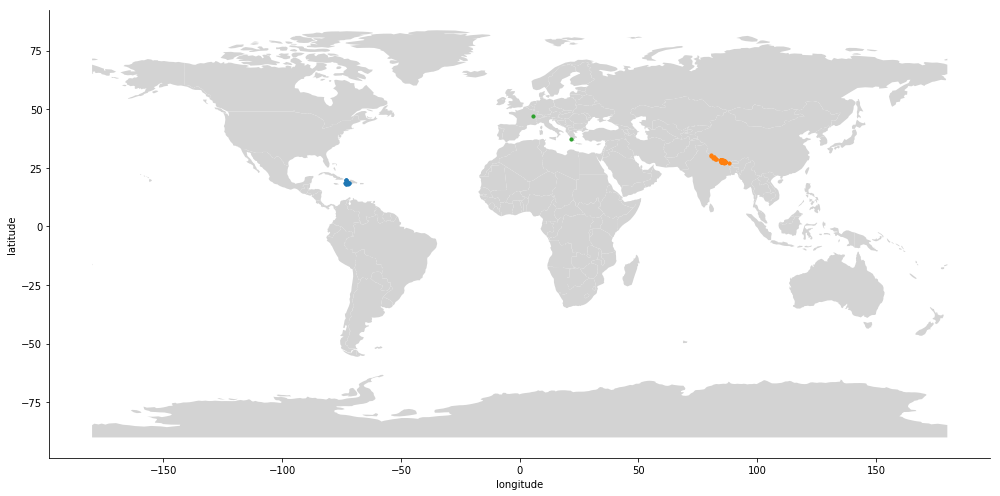

In [31]:
haiti['placename'] = len(haiti)*['haiti']
kathmandu['placename'] = len(kathmandu)*['kathmandu']
paris = find_place('paris')
paris['placename'] = len(paris)*['paris']  # Zie het, je kan het niet persee vertrouwen.

g = sns.FacetGrid(data=pandas.concat([haiti, kathmandu, paris]), hue='placename', size=7, aspect=2)
plot_world(g.axes[0][0])
g.map(plt.scatter, 'longitude', 'latitude', s=10)

## Appendix nucleare testen
Veel testen zijn na het begin van de data(1970) <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/Worldwide_nuclear_testing_multilang.svg/1125px-Worldwide_nuclear_testing_multilang.svg.png"> 

Dus de eerder plot waar ze in Rusland zitten lijkt een beetje vreemd. Ik dacht eerst dat ze het
verkeert gelabeld hadden, maar nu denk ik dat the punten gewoon overlapten:

Locaties selecteren in Amerika.

336

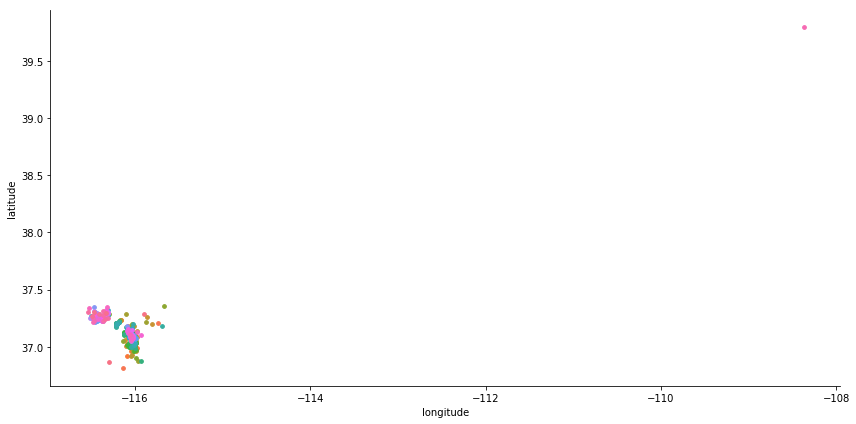

In [32]:
us_nuke_tests = data[data.longitude.between(-150,-70) & data.latitude.between(15,50)\
                     & (data.type == 'nuclear explosion')]
g = sns.FacetGrid(us_nuke_tests, hue='mag',
                  size=6, aspect=2)
#plot_world(g.axes[0][0])
g.map(plt.scatter, 'longitude', 'latitude', s=14)
len(us_nuke_tests)  # Apparently not everything registered as an Earthquake in this data.

En de Franse testen zitten ook in een klein gebied:

77

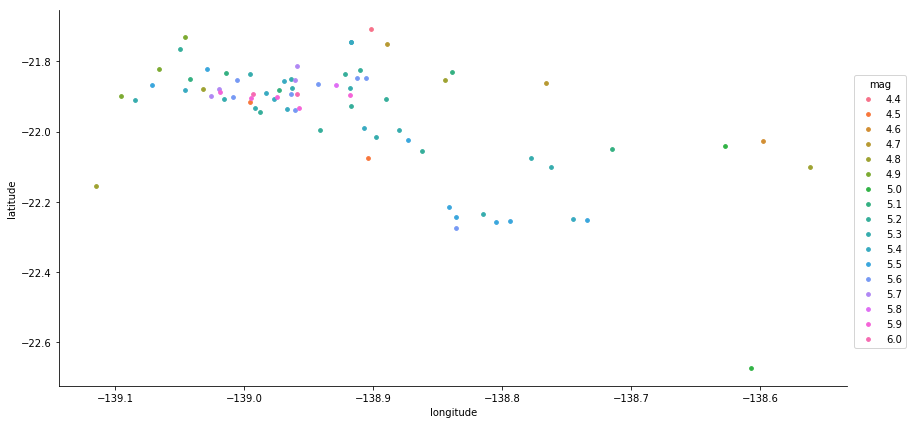

In [33]:
french_nuke_tests = data[data.latitude.between(-45,-10) & (data.type == 'nuclear explosion')]
g = sns.FacetGrid(data=french_nuke_tests, hue='mag',
                  size=6, aspect=2)
#plot_world(g.axes[0][0])
g.map(plt.scatter, 'longitude', 'latitude', s=14).add_legend()
len(french_nuke_tests)

Niet echt een analyse hiervan, wou alleen kijken omdat de Franse/Amerikaanse testen niet duidelijk in
de eerste plot hier was.

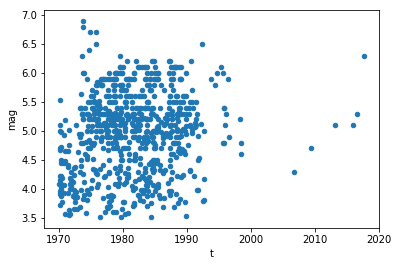

In [39]:
nukes = data[data.type=='nuclear explosion'][['time', 'mag']]

nukes['t'] = [year_continuous(date) for date in nukes.time]
nukes.plot.scatter(x='t', y='mag')